In [34]:
import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np
import glob, os

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors, cluster, preprocessing

from pandas_datareader import data, wb
import datetime

%pylab inline
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


## ETF ticker loader

In [17]:
tickers_df = pd.read_html('http://etfdb.com/screener/')
tickers_df = tickers_df[0]

In [18]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

for s in tickers_df.Symbol[0:1000]:
    try:
        t = data.DataReader(s, 'yahoo', start, end)
        t_close = pd.Series(t['Adj Close'], name=s)
        t_close.to_hdf('./tickers/' + s + '.h5', 'adjclose')
        
    except Exception:
        print('Problem with downloading - ', s)
        

Problem with downloading -  IBDA


In [154]:
ticker_folder = './zscore_tickers/'

In [ ]:
temp_data_l = []
temp_name_l = []

tickers_df = pd.DataFrame()

direction_flag = 'long'

for file in glob.glob(ticker_folder + "*.h5"):
    
    if direction_flag == 'long':
        ticker = pd.read_hdf(file)
        
    elif direction_flag == 'short':
        ticker = (pd.read_hdf(file)) * -1
    
    else:
        raise Exception('Invalid long/short flag. Set flag to "long" or "short"')
    
    
    
        

    if int(ticker.index.year[0]) <= 2011: 
        tickers_df[ticker.name] = ticker

        price_change = ticker - ticker.shift(1)
        max_dd = (ticker - ticker.expanding().max()).min()

        period_end_price = ticker[-1]
        period_start_price = ticker[0]
        
        median_vola = (ticker - ticker.shift(1)).rolling(30).median()
        
        
        dd_lengths_d = {}

        for y in numpy.unique(ticker.index.year):

            expmax = ticker.ix[str(y)].expanding().max()

            same_max_bars = np.zeros_like(expmax.values)
            same_max_counter = 0

            for i in range(len(expmax)):
                if expmax[i] == expmax.shift(1)[i]:
                    same_max_counter += 1
                    same_max_bars[i] = same_max_counter

                elif expmax[i] != expmax.shift(1)[i]:
                    same_max_counter = 0
                    same_max_bars[i] = same_max_counter

            dd_lengths_d[y] = np.mean(same_max_bars)
            #print(pd.Series(same_max_bars, index=expmax.index).mean())#.plot(secondary_y=True)
            
        for period in [1,2,5]:
            
            consec_up_bars = np.zeros_like(ticker.values)
            up_counter = 0

            consec_dn_bars = np.zeros_like(ticker.values)
            dn_counter = 0

            for i in range(len(ticker)):
                if ticker[i] > ticker.shift(period)[i]:
                    up_counter += 1
                    consec_up_bars[i] = up_counter

                elif ticker[i] < ticker.shift(period)[i]:
                    up_counter = 0
                    consec_up_bars[i] = up_counter



                if ticker[i] < ticker.shift(period)[i]:
                    dn_counter += 1
                    consec_dn_bars[i] = dn_counter

                elif ticker[i] > ticker.shift(period)[i]:
                    dn_counter = 0
                    consec_dn_bars[i] = dn_counter

            updn_consec_bars_df = pd.concat([pd.Series(consec_up_bars,name='consec_up_bars'), 
                                             pd.Series(consec_dn_bars,name='consec_dn_bars')], axis=1).drop(0)

            #
            # Same thing for 1-2-5 period shift
            #
            d['average_consec_up_bars_shiftperiod'+str(period)] = updn_consec_bars_df.consec_up_bars.mean()
            d['average_consec_dn_bars_shiftperiod'+str(period)] = updn_consec_bars_df.consec_dn_bars.mean()
            d['average_consec_updn_bars_ratio_shiftperiod'+str(period)] = (updn_consec_bars_df.consec_up_bars.value_counts() / updn_consec_bars_df.consec_dn_bars.value_counts()).mean()
    
        for period in [5,10,30]:
            ema = ticker.ewm(period).mean()

            crossup = CrossUp(ticker, ema)
            crossdn = CrossDown(ticker, ema)

            days_wo_crossings_count = np.zeros_like(ticker.values)
            days_wo_crossings_counter = 0

            for i in range(len(ticker)):
                if (crossup[i] == False) | (crossdn[i] == False):
                    days_wo_crossings_counter += 1
                    days_wo_crossings_count[i] = days_wo_crossings_counter

                if (crossup[i] == True) | (crossdn[i] == True):
                    days_wo_crossings_counter = 0
                    days_wo_crossings_count[i] = days_wo_crossings_counter
                    
            d['median_days_wo_crossings_ema'+str(period)] = pd.Series(days_wo_crossings_count).median()
            d['quantile90_days_wo_crossings_ema'+str(period)] = pd.Series(days_wo_crossings_count).quantile(0.8)
        
        
        d = {'pricechange_modsharpe': np.mean(price_change) / np.std(price_change), 'max_dd': max_dd, 
             'recovery_factor': period_end_price / np.abs(max_dd), 
             'pct_change1_skew': ticker.pct_change(1).skew(), 'pct_change1_mean': ticker.pct_change(1).mean(),
             'pct_change1_std': ticker.pct_change(1).std(), 'pct_change1_var': ticker.pct_change(1).var(),
             'pct_change5_skew': ticker.pct_change(5).skew(), 'pct_change5_mean': ticker.pct_change(5).mean(),
             'pct_change5_std': ticker.pct_change(5).std(), 'pct_change5_var': ticker.pct_change(5).var(),
             'price_var': ticker.var(), 'price_std': ticker.std(), 'median_vola_median': median_vola.median(),
             'median_vola_quantile90': median_vola.quantile(0.9), 'median_vola_quantile10': median_vola.quantile(0.1),
             'median_vola_range': median_vola.quantile(0.9) - median_vola.quantile(0.1), 'average_dd_length': np.mean(list(dd_lengths_d.values())),
            }
        
        #for k in dd_lengths_d.keys():
        #    d['average_dd_length_in_'+str(k)] = dd_lengths_d[k]
            

        temp_data_l.append(d)
        temp_name_l.append(ticker.name)

In [156]:
#ticker = pd.read_hdf('./tickers\\MFLA.h5')
#ticker

In [157]:
ticker_stats_df = pd.DataFrame(temp_data_l, index=temp_name_l).dropna()
ticker_stats_df.sort_values('average_dd_length', ascending=True)

KeyError: 'average_dd_length'

In [158]:
tickers_df[ticker_stats_df.sort_values('average_dd_length', ascending=True).index[12]].plot()

KeyError: 'average_dd_length'

# Clustering model

In [159]:
ticker_stats_df2 = pd.DataFrame(preprocessing.normalize(ticker_stats_df), index=ticker_stats_df.index,
                                         columns=ticker_stats_df.columns)

In [160]:
clustering_model = cluster.KMeans(10)
clustering_model.fit(ticker_stats_df2.as_matrix())

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [161]:
ticker_stats_df['cluster'] = clustering_model.labels_

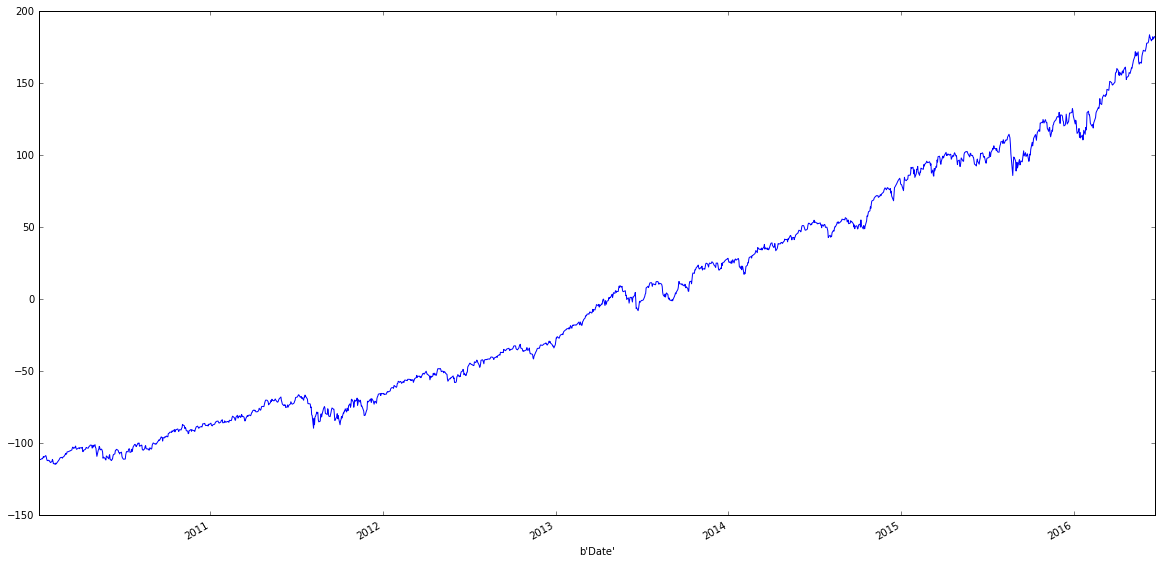

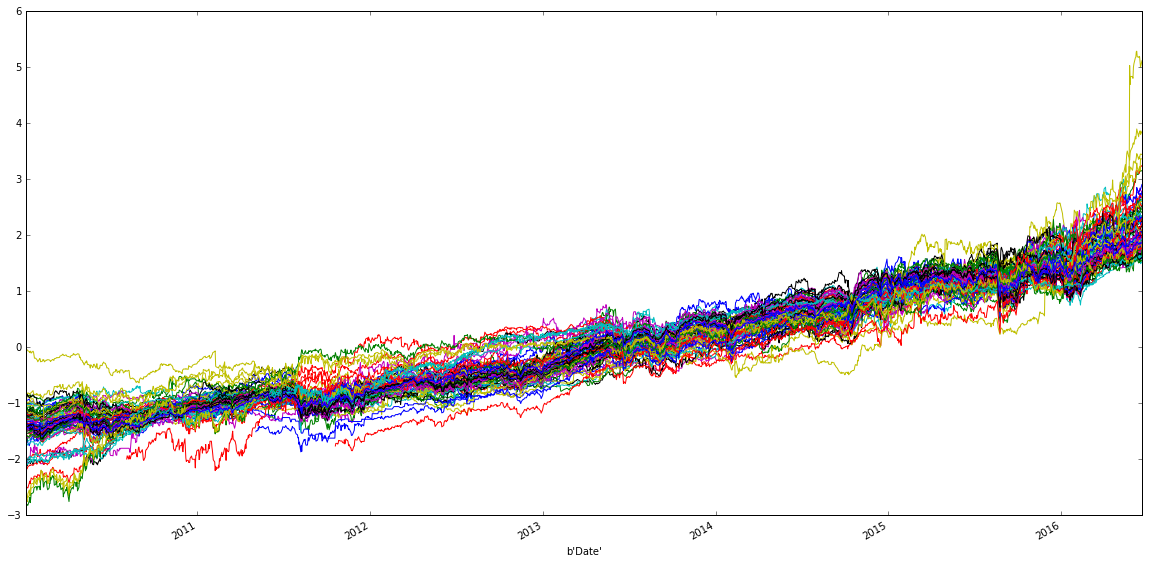

In [175]:
figsize(20,10)

# Change this variable to select a strategies in the cluster
cluster_n = 2


tickers_df[ticker_stats_df[ticker_stats_df.cluster == cluster_n].index].sum(1).plot(legend=False)
tickers_df[ticker_stats_df[ticker_stats_df.cluster == cluster_n].index].plot(legend=False)

In [138]:
ticker_stats_df[ticker_stats_df.cluster == cluster_n]
ticker_stats_df.cluster.describe()

count    1081.000000
mean        0.338575
std         0.705850
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: cluster, dtype: float64

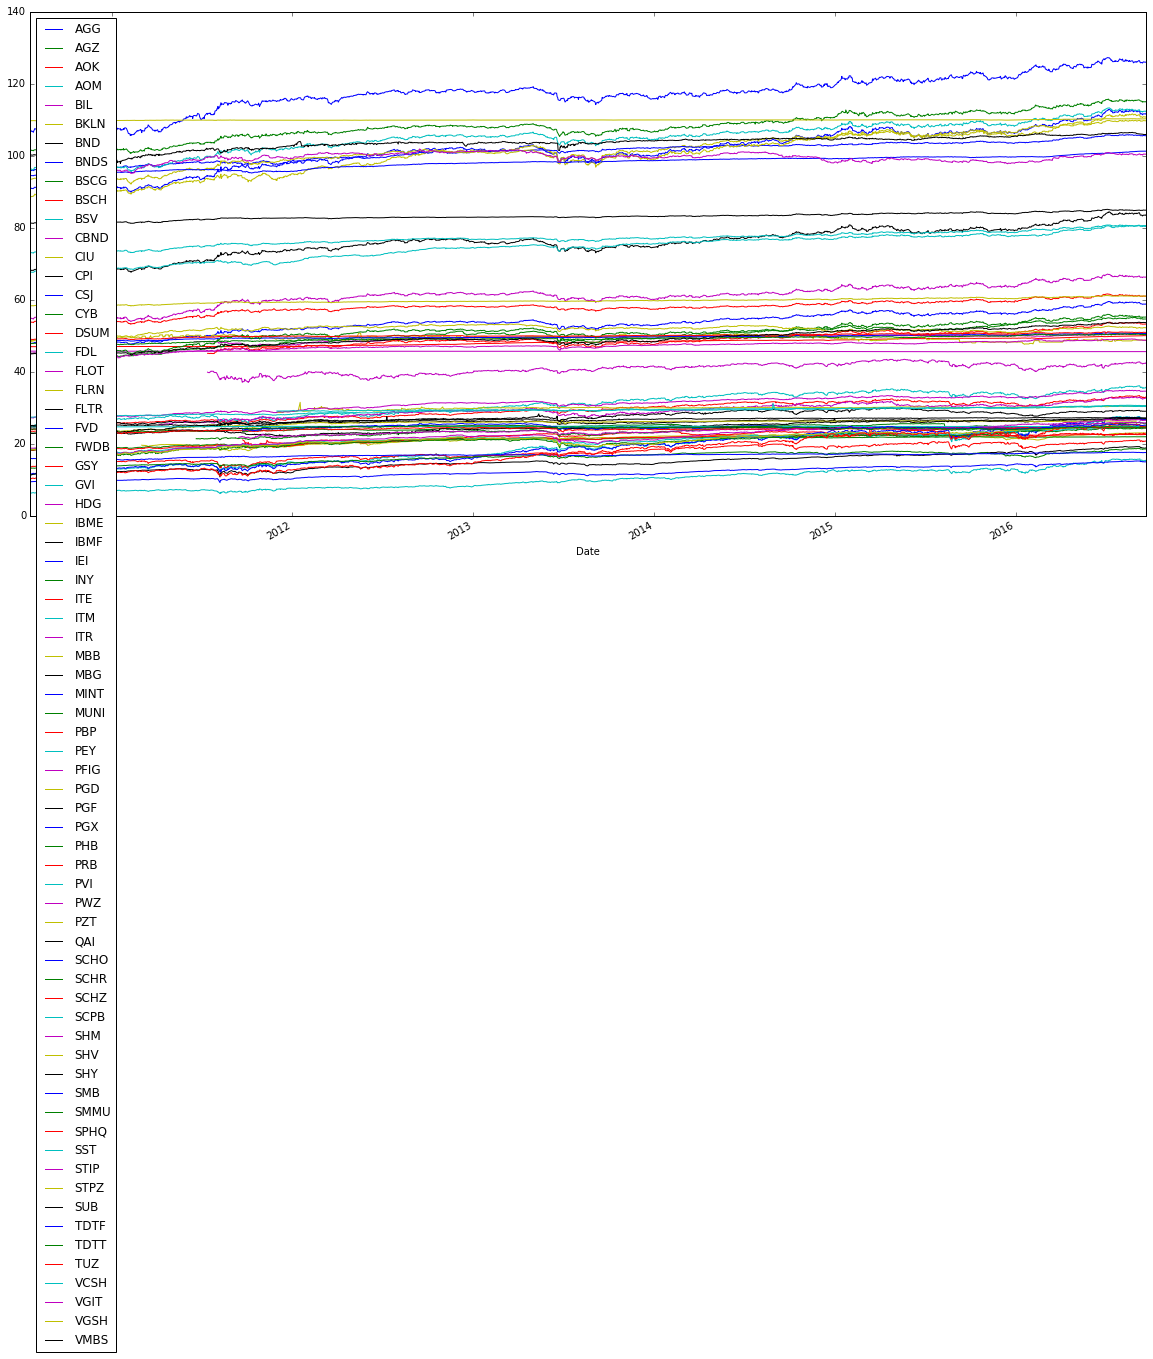

In [92]:
tickers_df[ticker_stats_df[ticker_stats_df.cluster == 1].index]#.plot()

# Features for clustering

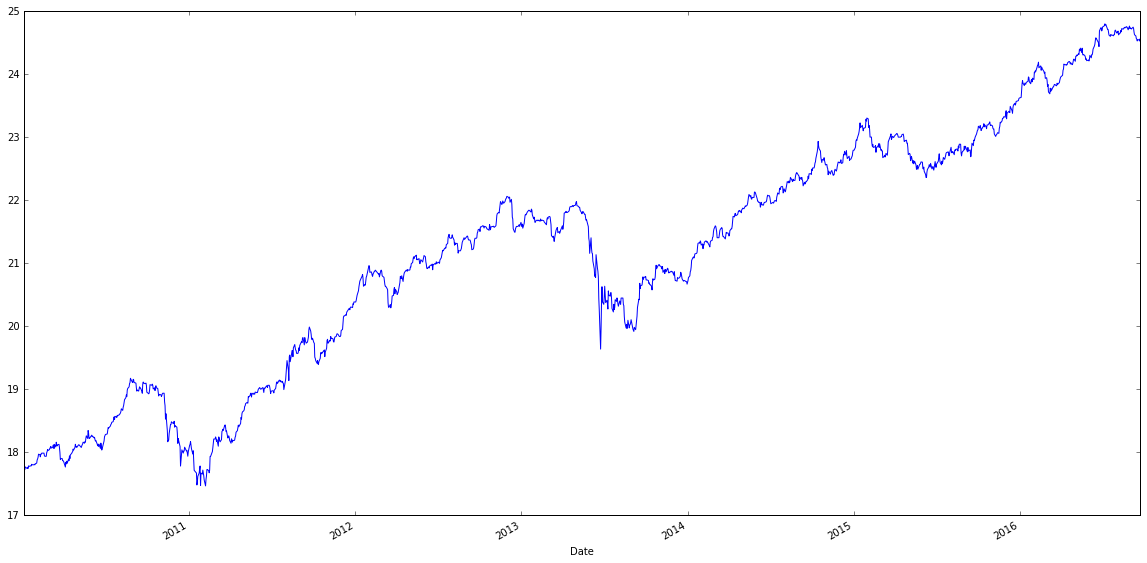

In [350]:
#ticker = tickers_df.sample(1, axis=1)

ticker.plot()

In [351]:
# Simple volatility stats
print(ticker.ix['2014'].std()) # overall stats and by year(?)
print(ticker.ix['2014'].var()) # overall stats and by year

0.5045624244930516
0.25458324021030637


In [352]:
# Simple ptice change stats
# Also for periods 5-10-20-100
print(ticker.pct_change(10).skew())
print(ticker.pct_change(10).mean())
print(ticker.pct_change(10).median())
print(ticker.pct_change(10).var())
print(ticker.pct_change(10).std())

-0.745166815667
0.0019879211600845274
0.002679791415225452
9.922599235027579e-05
0.009961224440312335


0.0148475


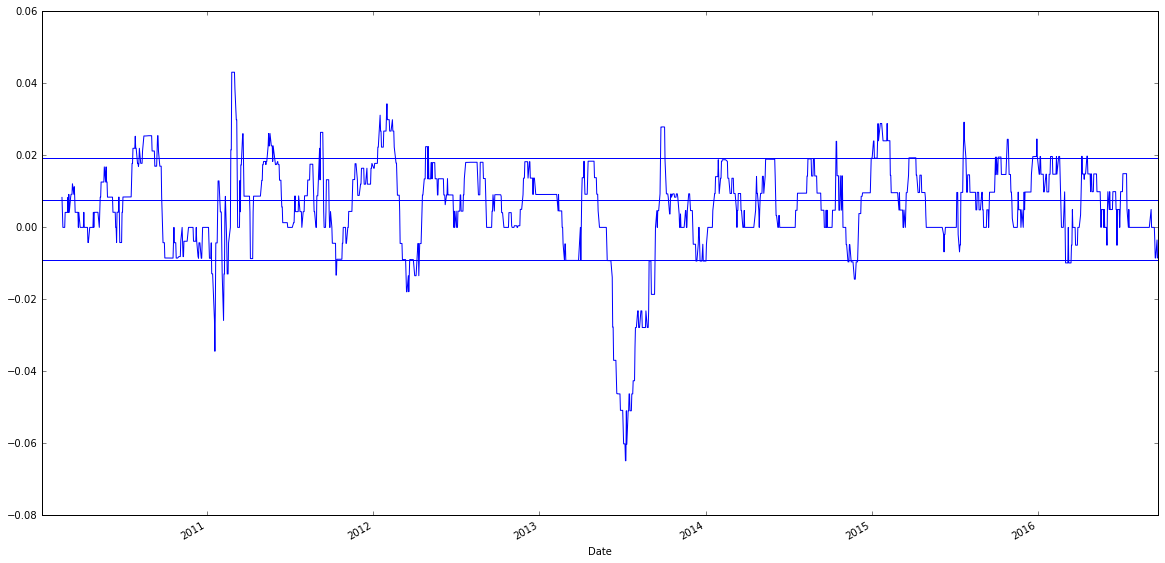

In [353]:
(ticker - ticker.shift(1)).rolling(30).median().plot()
(ticker - ticker.shift(1)).rolling(30).median().median()
axhline((ticker - ticker.shift(1)).rolling(30).median().median())

axhline((ticker - ticker.shift(1)).rolling(30).median().quantile(.9))
axhline((ticker - ticker.shift(1)).rolling(30).median().quantile(.1))

# Volatility range
print(((ticker - ticker.shift(1)).rolling(30).median().quantile(.8) - (ticker - ticker.shift(1)).rolling(30).median().quantile(.2)))

20.99206349206349
9.738095238095237
16.128
62.964285714285715
11.785714285714286
86.51190476190476
15.302197802197803


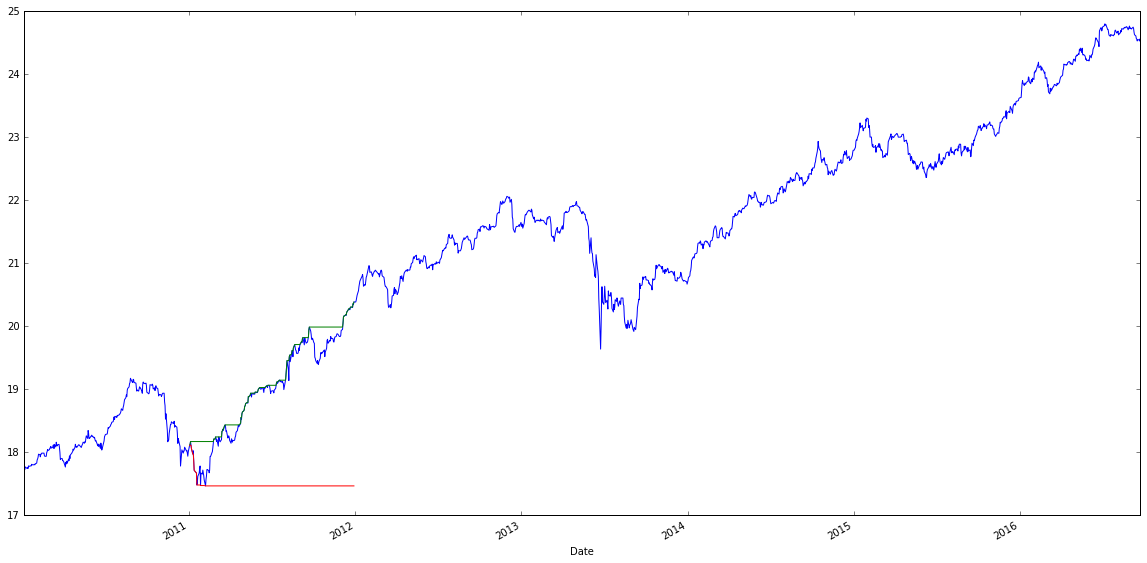

In [368]:
# Days after renewing a historical low or high
# Length of drawdowns ?
ticker.plot()

ticker.ix['2011'].expanding().max().plot()
ticker.ix['2011'].expanding().min().plot()

dd_lengths_d = {}

for y in numpy.unique(ticker.index.year):
    
    expmax = ticker.ix[str(y)].expanding().max()

    same_max_bars = np.zeros_like(expmax.values)
    same_max_counter = 0

    for i in range(len(expmax)):
        if expmax[i] == expmax.shift(1)[i]:
            same_max_counter += 1
            same_max_bars[i] = same_max_counter

        elif expmax[i] != expmax.shift(1)[i]:
            same_max_counter = 0
            same_max_bars[i] = same_max_counter
    
    dd_lengths_d[y] = np.mean(same_max_bars)
    print(pd.Series(same_max_bars, index=expmax.index).mean())#.plot(secondary_y=True)

In [388]:
np.mean(list(dd_lengths_d.values()))

31.917465899180183

In [356]:
# Consecutive up/down bars count, ratios

consec_up_bars = np.zeros_like(ticker.values)
up_counter = 0

consec_dn_bars = np.zeros_like(ticker.values)
dn_counter = 0

for i in range(len(ticker)):
    if ticker[i] > ticker.shift(1)[i]:
        up_counter += 1
        consec_up_bars[i] = up_counter
        
    elif ticker[i] < ticker.shift(1)[i]:
        up_counter = 0
        consec_up_bars[i] = up_counter
      
    
    
    if ticker[i] < ticker.shift(1)[i]:
        dn_counter += 1
        consec_dn_bars[i] = dn_counter
        
    elif ticker[i] > ticker.shift(1)[i]:
        dn_counter = 0
        consec_dn_bars[i] = dn_counter
        
updn_consec_bars_df = pd.concat([pd.Series(consec_up_bars,name='consec_up_bars'), 
                                 pd.Series(consec_dn_bars,name='consec_dn_bars')], axis=1).drop(0)

#
# Same thing for 1-2-5 period shift
#

print(updn_consec_bars_df.consec_up_bars.mean())

print(updn_consec_bars_df.consec_dn_bars.mean())

print((updn_consec_bars_df.consec_up_bars.value_counts() / updn_consec_bars_df.consec_dn_bars.value_counts()).mean())

1.273211117681845
0.7492607924305145
3.1783788921049747


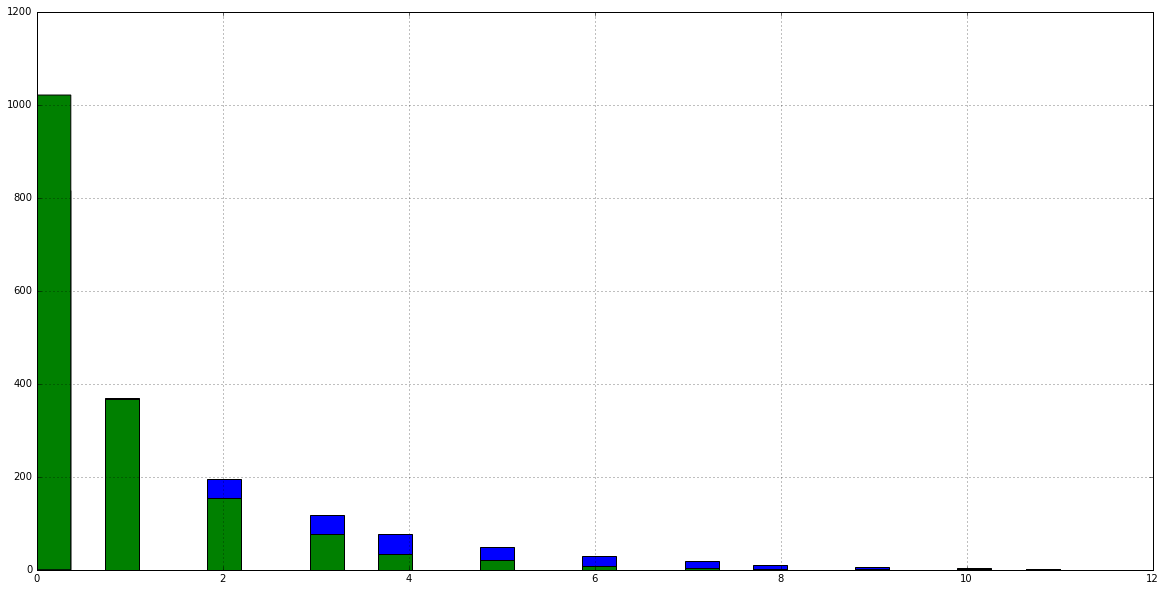

In [357]:
pd.Series(consec_up_bars).hist(bins=30)#.plot()
pd.Series(consec_dn_bars).hist(bins=30)#.plot()

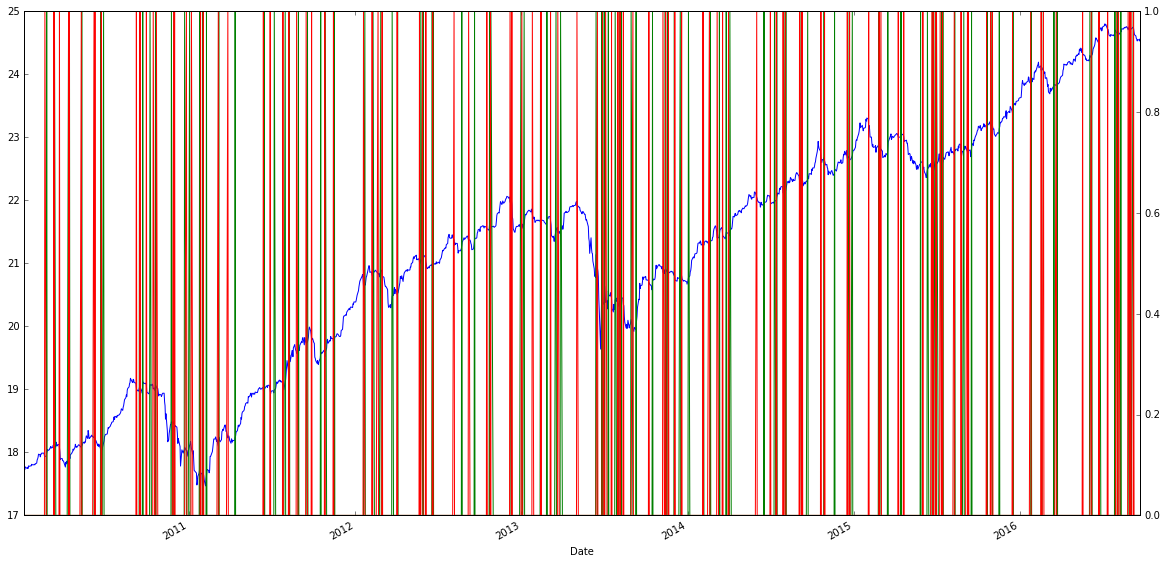

In [363]:
# Defining a Trend/meanrev regimes by EMA crossing

# Periods for EMA 5-10-30
ema = ticker.ewm(5).mean()

ticker.plot()
CrossUp(ticker, ema).plot(secondary_y=True)
CrossDown(ticker, ema).plot(secondary_y=True)

crossup = CrossUp(ticker, ema)
crossdn = CrossDown(ticker, ema)

days_wo_crossings_count = np.zeros_like(ticker.values)
days_wo_crossings_counter = 0

for i in range(len(ticker)):
    if (crossup[i] == False) | (crossdn[i] == False):
        days_wo_crossings_counter += 1
        days_wo_crossings_count[i] = days_wo_crossings_counter
                
    if (crossup[i] == True) | (crossdn[i] == True):
        days_wo_crossings_counter = 0
        days_wo_crossings_count[i] = days_wo_crossings_counter

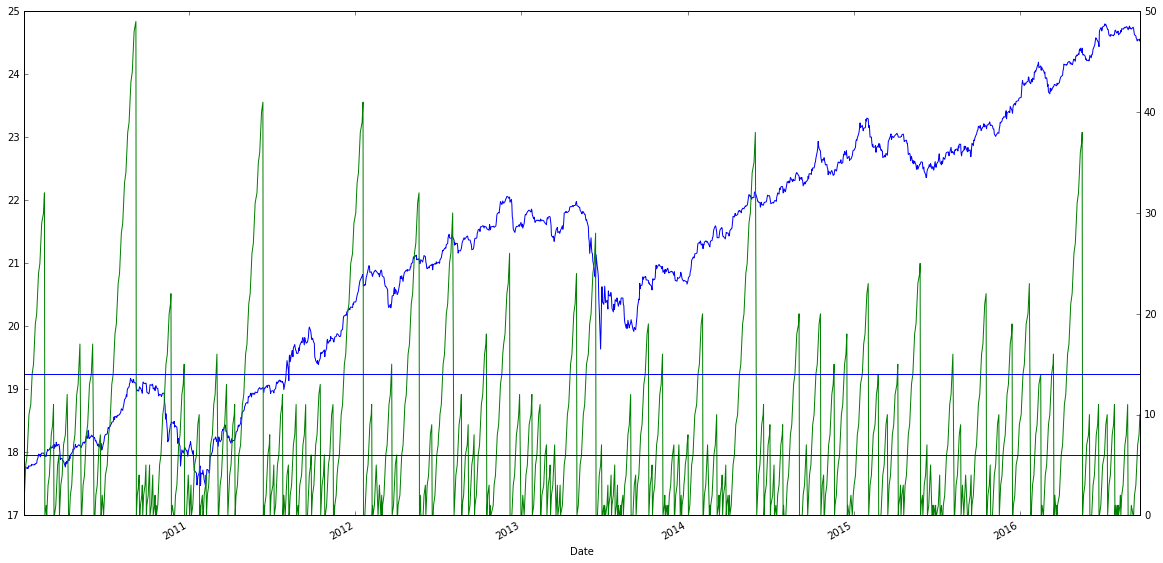

In [364]:
ticker.plot()
#CrossUp(ticker, ema).plot(secondary_y=True)
#CrossDown(ticker, ema).plot(secondary_y=True)

pd.Series(crossings_count, index=ticker.index).plot(secondary_y=True)
#axhline(pd.Series(crossings_count, index=ticker.index).mean())

axhline(pd.Series(crossings_count, index=ticker.index).median())

#axhline(pd.Series(crossings_count, index=ticker.index).quantile(0.9))

axhline(pd.Series(crossings_count, index=ticker.index).quantile(0.8))

In [360]:
pd.Series(crossings_count, index=ticker.index).mean()

43.35992907801418